In [193]:
import pandas as pd
from collections import defaultdict
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

#Scikit learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score,roc_curve, confusion_matrix, auc

In [161]:
#Import and look at data
churn = pd.read_csv('churn.csv')
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [162]:
churn.info() #3333 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Int'l Plan        3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 546.9+ KB


In [163]:
#Encode categorical data
state = LabelEncoder()
state.fit(churn.State)

churn_ = LabelEncoder()
churn_.fit(churn['Churn?'])

intplan = LabelEncoder()
intplan.fit(churn["Int'l Plan"])

vmail = LabelEncoder()
vmail.fit(churn['VMail Plan'])

#make panda series to concatenate to df
churn_enc = pd.Series(churn_.transform(churn['Churn?']), name="Churn")
state_enc = pd.Series(state.transform(churn.State), name="State")
intplan_enc = pd.Series(intplan.transform(churn["Int'l Plan"]), name='Intl_Plan')
vmail_enc = pd.Series(vmail.transform(churn['VMail Plan']), name='Vmail_plan')

churn_df = pd.concat([state_enc, intplan_enc, vmail_enc, 
                      churn.drop(['State', 'Churn?', "Int'l Plan", 'VMail Plan'],
                                    axis=1), churn_enc], axis=1)
churn_df.head()

,State,Intl_Plan,Vmail_plan,Account Length,Area Code,Phone,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,16,0,1,128,415,382-4657,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,0,1,107,415,371-7191,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,0,0,137,415,358-1921,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,1,0,84,408,375-9999,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,1,0,75,415,330-6626,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [164]:
churn_df.corr()

,State,Intl_Plan,Vmail_plan,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
State,1.000000,-0.004597,-0.031664,0.003678,0.015814,-0.027762,-0.006737,-0.000764,-0.006736,0.013682,-0.016268,0.013674,0.024576,0.007458,0.024572,-0.007834,0.013967,-0.007819,-0.025861,0.007780
Intl_Plan,-0.004597,1.000000,0.006006,0.024735,0.048551,0.008745,0.049396,0.003755,0.049398,0.019100,0.006114,0.019106,-0.028905,0.012451,-0.028913,0.045871,0.017366,0.045780,-0.024522,0.259852
Vmail_plan,-0.031664,0.006006,1.000000,0.002918,-0.000747,0.956927,-0.001684,-0.011086,-0.001686,0.021545,-0.006444,0.021559,0.006079,0.015553,0.006064,-0.001318,0.007618,-0.001276,-0.017824,-0.102148
Account Length,0.003678,0.024735,0.002918,1.000000,-0.012463,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796,0.016541
Area Code,0.015814,0.048551,-0.000747,-0.012463,1.000000,-0.001994,-0.008264,-0.009646,-0.008264,0.003580,-0.011886,0.003607,-0.005825,0.016522,-0.005845,-0.018288,-0.024179,-0.018395,0.027572,0.006174
VMail Message,-0.027762,0.008745,0.956927,-0.004628,-0.001994,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263,-0.089728
Day Mins,-0.006737,0.049396,-0.001684,0.006216,-0.008264,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423,0.205151
Day Calls,-0.000764,0.003755,-0.011086,0.038470,-0.009646,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942,0.018459
Day Charge,-0.006736,0.049398,-0.001686,0.006214,-0.008264,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427,0.205151
Eve Mins,0.013682,0.019100,0.021545,-0.006757,0.003580,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985,0.092796


In [165]:
# Throw out columns that have a perfect correlation
churn_df.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge', 'VMail Message'], axis=1, inplace=True)

In [166]:
churn_df.head()

,State,Intl_Plan,Vmail_plan,Account Length,Area Code,Phone,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn
0,16,0,1,128,415,382-4657,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,35,0,1,107,415,371-7191,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,31,0,0,137,415,358-1921,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,35,1,0,84,408,375-9999,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,36,1,0,75,415,330-6626,166.7,113,148.3,122,186.9,121,10.1,3,3,0


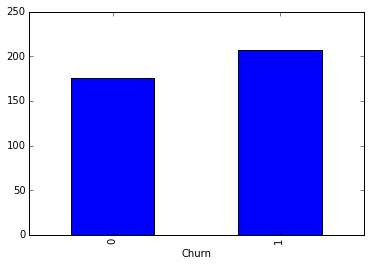

In [167]:
# Look at distribution of remaining features
churn_df['Day Mins'].groupby(churn_df['Churn']).mean().plot('bar');

In [168]:
daymin_churn = churn_df['Day Mins'][churn_df['Churn'] == 1]
daymin_noChurn = churn_df['Day Mins'][churn_df['Churn'] == 0]
ss.ttest_ind(daymin_churn, daymin_noChurn, equal_var=False)
#People with more day minutes churn significantly more than those with less day minutes

Ttest_indResult(statistic=9.684562957319736, pvalue=1.2189683063650911e-20)

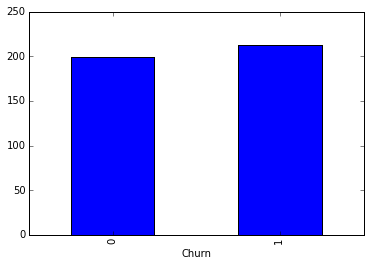

In [169]:
churn_df['Eve Mins'].groupby(churn_df['Churn']).mean().plot('bar');

In [170]:
evemin_churn = churn_df['Eve Mins'][churn_df['Churn'] == 1]
evemin_noChurn = churn_df['Eve Mins'][churn_df['Churn'] == 0]
ss.ttest_ind(evemin_churn, evemin_noChurn, equal_var=False)
#People with more evening minutes churn significantly more than those with less evening minutes

Ttest_indResult(statistic=5.272354178713746, pvalue=1.8390798282238121e-07)

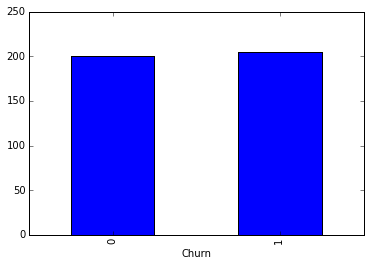

In [171]:
churn_df['Night Mins'].groupby(churn_df['Churn']).mean().plot('bar');

In [172]:
nightmin_churn = churn_df['Night Mins'][churn_df['Churn'] == 1]
nightmin_noChurn = churn_df['Night Mins'][churn_df['Churn'] == 0]
ss.ttest_ind(nightmin_churn, nightmin_noChurn, equal_var=False)
#People with more night minutes churn significantly more than those with less night minutes

Ttest_indResult(statistic=2.1708889020090862, pvalue=0.030280490212476915)

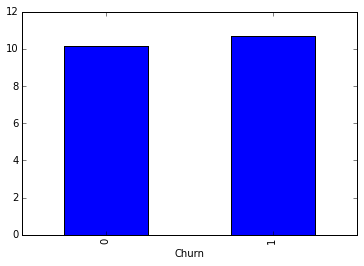

In [173]:
churn_df['Intl Mins'].groupby(churn_df['Churn']).mean().plot('bar');

In [174]:
intlmin_churn = churn_df['Intl Mins'][churn_df['Churn'] == 1]
intlmin_noChurn = churn_df['Intl Mins'][churn_df['Churn'] == 0]
ss.ttest_ind(intlmin_churn, intlmin_noChurn, equal_var=False)
#People with more international minutes churn significantly more than those with less international minutes

Ttest_indResult(statistic=3.9388511152723553, pvalue=9.065714718803045e-05)

*** Customers that use more minutes churn more than those who don't use their minutes as much***

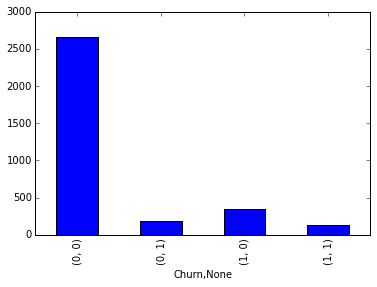

In [175]:
churn_df['Intl_Plan'].groupby(churn_df['Churn']).value_counts().plot('bar'); 
#People who had the Int'l Plan churned more

In [176]:
intlplan_churn_00 = churn_df['Intl_Plan'][(churn_df['Churn'] == 0) | (churn_df['Intl_Plan'] == 0)]
intlplan_churn_01 = churn_df['Intl_Plan'][(churn_df['Churn'] == 0) | (churn_df['Intl_Plan'] == 1)]
intlplan_churn_10 = churn_df['Intl_Plan'][(churn_df['Churn'] == 1) | (churn_df['Intl_Plan'] == 0)]
intlplan_churn_11 = churn_df['Intl_Plan'][(churn_df['Churn'] == 1) | (churn_df['Intl_Plan'] == 1)]

print ss.ttest_ind(intlplan_churn_00, intlplan_churn_01, equal_var=False)
print ss.ttest_ind(intlplan_churn_00, intlplan_churn_10, equal_var=False)
print ss.ttest_ind(intlplan_churn_00, intlplan_churn_11, equal_var=False)

print ss.ttest_ind(intlplan_churn_10, intlplan_churn_01, equal_var=False)
print ss.ttest_ind(intlplan_churn_10, intlplan_churn_11, equal_var=False)

print ss.ttest_ind(intlplan_churn_01, intlplan_churn_11, equal_var=False)
#People without the international plan churn significantly less than those with the international plan

Ttest_indResult(statistic=-7.1011631955422478, pvalue=1.3928232038452563e-12)
Ttest_indResult(statistic=2.6600519489053411, pvalue=0.0078328069222307548)
Ttest_indResult(statistic=-21.474552869055177, pvalue=1.1235353488855019e-79)
Ttest_indResult(statistic=-9.573684581238691, pvalue=1.5611363171062443e-21)
Ttest_indResult(statistic=-22.328403463778795, pvalue=3.2009483204184763e-84)
Ttest_indResult(statistic=-18.592349018563578, pvalue=3.051201083961959e-64)


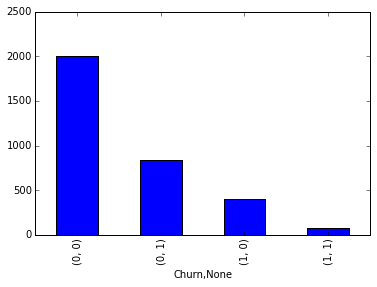

In [177]:
churn_df['Vmail_plan'].groupby(churn_df['Churn']).value_counts().plot('bar'); 
# people who did not have the vmail plan churned more

In [178]:
vmplan_churn_00 = churn_df['Vmail_plan'][(churn_df['Churn'] == 0) | (churn_df['Vmail_plan'] == 0)]
vmplan_churn_01 = churn_df['Vmail_plan'][(churn_df['Churn'] == 0) | (churn_df['Vmail_plan'] == 1)]
vmplan_churn_10 = churn_df['Vmail_plan'][(churn_df['Churn'] == 1) | (churn_df['Vmail_plan'] == 0)]
vmplan_churn_11 = churn_df['Vmail_plan'][(churn_df['Churn'] == 1) | (churn_df['Vmail_plan'] == 1)]

print ss.ttest_ind(vmplan_churn_00, vmplan_churn_10, equal_var=False)
print ss.ttest_ind(vmplan_churn_00, vmplan_churn_11, equal_var=False)

print ss.ttest_ind(vmplan_churn_10, vmplan_churn_01, equal_var=False)

print ss.ttest_ind(vmplan_churn_10, vmplan_churn_11, equal_var=False)

print ss.ttest_ind(vmplan_churn_01, vmplan_churn_11, equal_var=False)

#People without the Vmail plan churn significantly less than those with the Vmail plan

Ttest_indResult(statistic=26.817387174814726, pvalue=4.0399214982729622e-147)
Ttest_indResult(statistic=-29.541062869631656, pvalue=2.1803596882449207e-163)
Ttest_indResult(statistic=-30.449581114501104, pvalue=8.9671939467732432e-183)
Ttest_indResult(statistic=-50.559996610447861, pvalue=0.0)
Ttest_indResult(statistic=-24.945873782760803, pvalue=3.21757854032881e-123)


*** Customers without the vmail and international plan churned less than those who had the plans.***

In [179]:
percentages = d = defaultdict(lambda:defaultdict(float))
total_cust_call = churn_df['CustServ Calls'].value_counts()
cust_call = churn_df['CustServ Calls'].groupby(churn_df['Churn']).value_counts()

for churn in [0,1]:
    for cust_call_key in total_cust_call.keys():
        try:
            percentages[churn][cust_call_key]=(cust_call[churn][cust_call_key]/(1.0*total_cust_call[cust_call_key]))
        except KeyError:
            continue

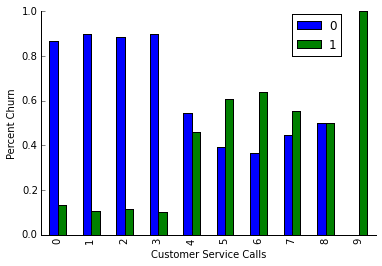

In [180]:
ax1 = pd.DataFrame(percentages).plot(kind='bar', label='False');

# Hide the right and top spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')

plt.xlabel('Customer Service Calls')
plt.ylabel('Percent Churn')
plt.legend(loc=[0.75,0.80]);

***100% of the customers who made 9 calls churned. Big increase in customers who churn once they make 4 calls***

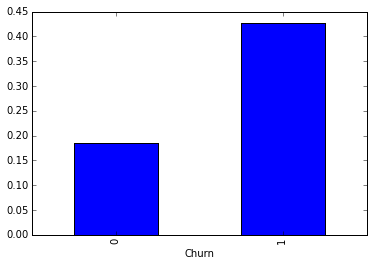

In [127]:
churn_df['CustServ Calls'].groupby(churn_df['Churn']).mean().plot('bar');

In [129]:
cust_churn_0 = churn_df['CustServ Calls'][churn_df['Churn'] == 0]
cust_churn_1 = churn_df['CustServ Calls'][churn_df['Churn'] == 1]

print ss.ttest_ind(cust_churn_0, cust_churn_1, equal_var=False)

#People with fewer customer service calls churn less than those with more calls

Ttest_indResult(statistic=-8.612085198029872, pvalue=7.3497448463849423e-17)


In [130]:
#put customer service calls in groups
def group_cust_calls(x):
    if x in [0,1,2]:
        return 0
    elif x in [3,4,5]:
        return 1
    elif x in [6,7,8,9]:
        return 2
    else:
        return 3

In [131]:
churn_df['CustServ Calls'] = churn_df['CustServ Calls'].map(group_cust_calls)

In [132]:
churn_df.head()

,State,Intl_Plan,Vmail_plan,Account Length,Area Code,Phone,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn
0,16,0,1,128,415,382-4657,265.1,110,197.4,99,244.7,91,10.0,3,0,0
1,35,0,1,107,415,371-7191,161.6,123,195.5,103,254.4,103,13.7,3,0,0
2,31,0,0,137,415,358-1921,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,35,1,0,84,408,375-9999,299.4,71,61.9,88,196.9,89,6.6,7,0,0
4,36,1,0,75,415,330-6626,166.7,113,148.3,122,186.9,121,10.1,3,0,0


In [182]:
X = churn_df.drop(['Churn', 'Area Code', 'Phone'], axis=1) #drop these because they nothing to do with churn
#scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [183]:
y = churn_df.Churn

In [198]:
lr = LogisticRegression()

In [199]:
f1 = []
kf = KFold(len(y), n_folds=5, shuffle=True)
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    predict_lr = lr.predict(X_test)
    f1.append(f1_score(y_test, predict_lr))

print("F1 score: ")
print np.mean(f1)
print('Accuracy score: %.2f' % np.mean(cross_val_score(lr, X, y)))

F1 score: 
0.307097933979
Accuracy score: 0.86


In [200]:
rf = RandomForestClassifier(n_estimators=20)

In [201]:
f1 = []
kf = KFold(len(y), n_folds=5, shuffle=True)
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf.fit(X_train, y_train)
    predict_rf = rf.predict(X_test)
    f1.append(f1_score(y_test, predict_rf))

print("F1 score: ")
print np.mean(f1)
print('Accuracy score: %.2f' % np.mean(cross_val_score(rf, X, y)))

F1 score: 
0.759483454136
Accuracy score: 0.94


In [206]:
# get counts of probability to churn
churn_prob_rf = rf.predict_proba(X_test)
churn_predict_rf = rf.predict(X_test)

churn_prediction = pd.Series(churn_predict_rf, name='prediction')
churn_prediction_prob = pd.Series(churn_prob_rf[:,1], name='churn_probability')

prob_counts = pd.Series(churn_prob_rf[:,1]).value_counts()
prob_counts

#Should target people with more than 50% chance of churning

0.00    209
0.05    155
0.10    102
0.15     41
0.20     31
0.55     15
0.25     12
0.75     12
0.70     12
0.30     12
0.80     12
0.60     10
0.65      9
0.40      8
0.50      7
0.85      7
0.90      4
0.35      4
0.95      2
0.45      2
dtype: int64

In [210]:
predict_churn = pd.concat([churn_prediction, churn_prediction_prob], axis=1)

In [212]:
predict_churn.head(10)

,prediction,churn_probability
0,0,0.25
1,0,0.10
2,0,0.00
3,0,0.05
4,0,0.35
5,0,0.00
6,1,0.60
7,0,0.10
8,0,0.15
9,0,0.05


In [213]:
# Target these customers to prevent churn
predict_churn[predict_churn.churn_probability > 0.5]

,prediction,churn_probability
6,1,0.60
21,1,0.85
23,1,0.75
34,1,0.85
36,1,0.60
41,1,0.70
42,1,0.65
52,1,0.75
54,1,0.90
60,1,0.55
